Ссылка на репозиторий проекта:
https://github.com/andrew-tvorogov/practicum_masterskaya_1

## Рекомендации для инвесторов о целесообразности инвестирования в стартапы на основе данных о стартапах, функционировавших в период с 1970 по 2018 годы.

<b>Заказчик исследования:</b>
- yandex practicum

<b>Источник данных:</b>
- псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) данные о стартапах, функционировавших в период с 1970 по 2018 годы

<b>Содержание данных:</b>
- данные о стартапах;

<b>Порядок проведения исследования:</b>
- загрузить данные;
- изучить данные;
- выполнить предобработку данных;
- полноценный разведочный анализ
    - провести исследовательский анализ;
    - провести корреляционный анализ признаков датасета;
- разработка новых синтетических признаков;
- проверка на мультиколлинеарность;
- отбор финального набора обучающих признаков;
- выбрать лучшую модель (выбор и обучение моделей);
    - создать пайплан обработки признаков;
    - создать пайплайн выбора лучшей модели.
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков;
- сделать общий вывод на основе готовых моделей (подготовка отчета по исследованию).

<b>Задача:</b>
<p>Разработать решение, которое позволит предсказать какие стартапы закроются.</p>

<b>Цель исследования:</b>
- снижение рисков при инвестировании в стартап;
- получение прибыли;

Данные доступны в файле ``kaggle_startups_train_28062024.csv``

<b>Описание данных:</b>

- ``name`` название стартапа;
- ``category_list`` cписок категорий, к которым относится стартап;
- ``funding_total_usd`` общая сумма финансирования в USD;
- ``status`` татус стартапа (закрыт или действующий);
- ``country_code`` код страны;
- ``state_code`` код штата;
- ``region`` регион;
- ``city`` город;
- ``funding_rounds`` количество раундов финансирования;
- ``founded_at`` дата основания;
- ``first_funding_at`` дата первого раунда финансирования;
- ``last_funding_at`` дата последнего раунда финансирования;
- ``closed_at`` дата закрытия стартапа (если применимо);
- ``lifetime`` время существования стартапа в днях.
</pre>

<b>Дополнительно:</b>

Для участия в соревновании на ресурсе Kaggle доступны дополнительные файлы:
- ``kaggle_startups_train_28062024.csv``
- ``kaggle_startups_sample_submit_28062024.csv``

In [1]:
# установка пакетов
# SHapley Additive exPlanations
#!pip install shap --quiet 

# correlation analyzer library
!pip install phik --quiet

In [2]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt # для диаграмм
import math # для диаграмм
import numpy as np # для равномерного распределения значений на диаграмме
import seaborn as sns
#import shap # оценка вклада признака
import phik

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler, 
    OneHotEncoder, 
    OrdinalEncoder)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

from warnings import simplefilter

In [3]:
# Функции

def dataset_info(df):
    '''
    Покажет сводную информацию по датасету
    '''
    cat_columns = df.select_dtypes('object').columns # категориальные
    num_columns = df.select_dtypes('float').columns # количественные
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    print(f'''\n''')
    df.info()
    print(f'''\n''')
    display(df.describe())
    if (len(list(datetime_columns)) > 0):
        display(startups_data[datetime_columns].agg(['min','max']))
        print(f'''\n''')
    print(f'''\n''')
    display(df.head(3))
    print(f'''\n\nЯвных дублей: {df.duplicated().sum()}\n\n''')
    print(f'''Пропущенных значений:\n{df.isna().sum()}\n\n''')

def dataset_tm_info(df):
    '''
    Покажет информацию по datetime колонкам датасета
    '''
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    if (len(list(datetime_columns)) > 0):
        display(startups_data[datetime_columns].agg(['min','max']))
        #print(f'''\n''')
    else:
        print(f'''Нет колонок типа datetime\n''')

# функция для отображения круговой диаграммы распределения количества элементов по категории
def show_category_pie(df, field, title):
    '''
    Отобразит круговую диаграмму распределения количества элементов по категории
    '''
    df[field]\
    .value_counts().plot(kind='pie', title = title + ', %', autopct='%1.0f%%', figsize=(7,7))
    plt.ylabel('')
    plt.show()

# функция для отображения количественных признаков в виде графиков - гистограммы и ящика с усами
def show_numeric_bplt_hist(df, variable, first_label, second_label, bins):
    '''
    Отобразит количественные признаки в виде графиков - гистограммы и ящика с усами
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(df[variable], bins=bins)
    ax1.set_title('Гистограмма')
    ax1.set_xlabel(first_label)
    ax1.set_ylabel(second_label)    
    ax1.grid(True)    
    
    ax2.boxplot(df[variable], vert=False)
    ax2.set_title('Ящик с усами')
    ax2.set_xlabel(first_label)
    ax2.set_ylabel(second_label)
    ax2.grid(True)
    ax2.set_yticks([])

    plt.show()    

def show_two_pies(df_1, df_2, title, field):
    '''
    Отобразит две круговые диаграммы распределения количества элементов по категории для двух датасетов
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df_1[field]\
        .value_counts().plot(kind='pie', title = title + ' - train, %', autopct='%1.0f%%', figsize=(14,7), ax=ax1)
    df_2[field]\
        .value_counts().plot(kind='pie', title = title + ' - test, %', autopct='%1.0f%%', figsize=(14,7), ax=ax2)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()
    
def show_two_barh(df_left, df_right, field, y_label, left_title, right_title):
    '''
    Отобразит две столбчатые диаграммы(горизонтальные) распределения количества элементов по категории для двух датасетов
    '''
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

    df_left[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[0], label='', ax=ax1)
    ax1.set_title(left_title)
    ax1.set_ylabel(y_label)    
    df_right[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[1], label='', ax=ax2)    
    ax2.set_title(right_title)
    plt.show()
        
def show_two_countplots(df_left, df_right, field, y_label, x_label, left_title, right_title, y_lim=(0, 100)):
    '''
    Отобразит две countplot диаграммы распределения количества элементов по категории для двух датасетов
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)

    left = sns.countplot(df_left[field], color=colors[0], ax=axes[0], alpha=0.5)
    left.set(xlabel=x_label, ylabel=y_label, title=left_title, ylim=y_lim)
    right = sns.countplot(df_right[field], color=colors[1], ax=axes[1], alpha=0.5)
    right.set(xlabel=x_label, ylabel=y_label, title=right_title, ylim=y_lim)

    plt.show()
    
def show_relative_table(df, main_field, req_field, req_field_value, title='', cmap='magma'):
    '''
    Отобразит таблицу частоты для признака по условию
    '''
    styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "110%"),
                              ("color", 'black')])]
    normalized_diff = train_quit[train_quit[req_field] == req_field_value][main_field]\
                        .value_counts(normalize=True) - train_quit[main_field].value_counts(normalize=True)    
    display(pd.DataFrame(normalized_diff).T.style\
            .background_gradient(cmap=cmap, axis=1)\
            .set_caption(title)\
            .set_table_styles(styles))

'''
Посчитает количество дней существования стартапа
'''
def count_lifetime(el):
    if el['status'] == 'operating':
        return (pd.to_datetime('2018-01-01') - el["founded_at"]).days # самая "правая" дата по условию 2018-01-01
    else:
        return (el['closed_at'] - el["founded_at"]).days

In [4]:
# инициализация глобальных переменных
RANDOM_STATE = 42 # Deep Thought number
TEST_SIZE = 0.25 # размер выборки

In [5]:
# настройки
pd.options.display.max_columns = None # необходимо чтобы head отобразил все колонки
plt.rcParams['figure.figsize'] = [15, 3] # размеры графика по умолчанию
sns.set(rc={'figure.figsize':(15, 10)}) # размеры графика seaborn по умолчанию
pd.set_option('display.float_format', '{:.2f}'.format) # отобразит в колонках округленные данные до 6-ти знаков

simplefilter(action='ignore', category=FutureWarning) # уберёт предупреждение "Set `keepdims`

## Загрузка и изучение данных

### Загрузка

In [6]:
# загрузка данных в датасеты
try:
    startups_data = pd.read_csv('./datasets/kaggle_startups_train_28062024.csv') # рабочий датасет
    startups_test = pd.read_csv('./datasets/kaggle_startups_test_28062024.csv') # датасет test для соревнования
    startups_submit = pd.read_csv('./datasets/kaggle_startups_sample_submit_28062024.csv')  # пример результата
except:
    print("Ошибка. Данные не загружены")

#### Сводная информация датасет - ``startups_data``

In [7]:
dataset_info(startups_data)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB




,funding_total_usd,funding_rounds
count,42447.00,52516.00
mean,18247480.66,1.74
std,187117301.32,1.37
min,1.00,1.00
25%,336027.50,1.00
50%,2000000.00,1.00
75%,10000000.00,2.00
max,30079503000.00,19.00


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN




Явных дублей: 0


Пропущенных значений:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64




<span style="color: darkgreen">Явных дублей нет. </span><br><span style="color: #f85c00">Есть пропущенные значения, которые необходимо заполнить, используя разные стратегии.<br>Типы данных выглядят нормально за исключением трёх атрибутов - **founded_at**, **first_funding_at** и **last_funding_at**, которые необходимо привести к типу **datetime64[ns]**.</span>

#### Сводная информация датасет - ``startups_test``

In [8]:
dataset_info(startups_test)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB




,funding_total_usd,funding_rounds,lifetime
count,10547.00,13125.00,13125.00
mean,16549102.70,1.71,3097.61
std,92172825.63,1.32,2128.36
min,1.00,1.00,52.00
25%,320000.00,1.00,1726.00
50%,2000000.00,1.00,2526.00
75%,10000000.00,2.00,3866.00
max,4715000000.00,15.00,17167.00


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295




Явных дублей: 0


Пропущенных значений:
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64




<span style="color: darkgreen">Явных дублей нет. </span><br><span style="color: #f85c00">Есть пропущенные значения, которые необходимо заполнить, используя разные стратегии.<br>Типы данных выглядят нормально за исключением двух атрибутов - **first_funding_at** и **last_funding_at**, которые необходимо привести к типу **datetime64[ns]**.</span>

#### Сводная информация датасет - ``startups_submit``

In [9]:
dataset_info(startups_submit)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB




,name,status
count,13125,13125
unique,13125,2
top,Xevo,operating
freq,1,6635


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed




Явных дублей: 0


Пропущенных значений:
name      0
status    0
dtype: int64




<span style="color: darkgreen">Явных дублей нет. Пропущенных значений нет. Типы данных - корректны. </span>

**Вывод:**
- Во всех трёх датасетах нет явных дублей;
- Датасет startups_submit - пример структуры результата для соревнований. В проекте не будет использован. Явных дублей, пропущенных значений в нём нет. Данные корректны. Структура понятна.
- Состав и количество колонок в ``startups_data`` и ``startups_test`` - отличаются.
    - ``startups_test`` содержит колонку **life_time**, которой нет в ``startups_data``
    - ``startups_data`` содержит колонку **founded_at** и **closed_at**, которых нет в ``startups_test``
- Поскольку результат для соревнования должен быть получен при использовании ``startups_test``, необходимо предварительно привести состав колонок ``startups_data`` к ``startups_test``. Колонка **life_time** может быть заполнена из колонок **founded_at** и **closed_at** простым подсчётом дней.

## Предобработка данных

### Приведение типов данных колонок к **datetime64**

#### ``startups_data`` - колонки "founded_at","first_funding_at","last_funding_at","closed_at"

In [10]:
date_cols = ["founded_at","first_funding_at","last_funding_at","closed_at"]
startups_data[date_cols] = startups_data[date_cols].astype("datetime64[ns]")

In [11]:
startups_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

#### ``startups_test`` - колонки "first_funding_at","last_funding_at"

In [12]:
date_cols = ["first_funding_at","last_funding_at"]
startups_test[date_cols] = startups_test[date_cols].astype("datetime64[ns]")

In [13]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<span style="color: darkgreen">Типы данных в столбцах датасетов - корректны.</span>

### Анализ данных колонок типа **datetime64**

#### Датасет -``startups_data``

In [14]:
dataset_tm_info(startups_data)

,founded_at,first_funding_at,last_funding_at,closed_at
min,1970-02-05,1977-05-15,1977-05-15,1983-10-06
max,2016-04-02,2015-12-05,2015-12-07,2017-10-21


#### Датасет - ``startups_test``

In [15]:
dataset_tm_info(startups_test)

,first_funding_at,last_funding_at
min,1977-05-15,1977-05-15
max,2015-12-05,2015-12-07


<span style="color: darkgreen">Минимальная и максимальная даты в обоих датасетах находятся в корректном диапазоне. Выбросов и странных значений - нет.</span>

### Приведение набора столбцов в датасетах к набору столбцов ``startups_test``

#### Добавление столбца **lifetime** к датасету ``startups_data``

Для добавления столбца используется предварительно определённая функция *count_lifetime*.

Количество дней подсчитывается исходя из даты основания **founded_at** и даты закрытия **closed_at**. Если дата закрытия не определена, то берётся дата ``2018-01-01`` (самая поздняя дата в датасете).

Проверка, что количество записей в колонке **status**, имеющих статус ``closed``, соответствует количеству записей в колонке **closed_at** и не ``NuT``.

In [16]:
len(startups_data[startups_data['closed_at'].notna()])

4917

In [17]:
len(startups_data[startups_data['status'] == 'closed'])

4917

Количество совпадает и равно 4917 - итого 4917 стартапов были закрыты и есть их дата закрытия.

In [18]:
startups_data['lifetime'] = startups_data.apply(count_lifetime, axis=1) # функция добавит новый столбец

In [19]:
startups_data.head(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998


<span style="color: darkgreen">Столбец **lifetime** добавлен.</span>

In [20]:
# разница, выраженная в днях
#startups_data["lifetime"] = \
#(pd.to_datetime('2018-01-01') - startups_data["founded_at"]).dt.days
#startups_data

#### Удаление из датасета ``startups_data`` колонок, которых нет в датасете ``startups_test`` - **founded_at** и **closed_at**

In [21]:
startups_data = startups_data.drop(columns=['founded_at', 'closed_at'])

In [22]:
startups_data.head(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998


In [23]:
startups_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  lifetime           52516 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 4.8+ MB


In [24]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<span style="color: darkgreen">**Набор столбцов в датасетах - корректен.** Целевой признак - **status** есть только в ``startups_data``</span>

#### Замена пропуска в колонке **name** на 'unknown' в датасете ``startups_data``

In [25]:
startups_data['name'].fillna('unknown', inplace=True)

In [26]:
startups_data['name'].isna().sum()

0

<span style="color: darkgreen">Пропуск в столбце **name** заполнен.</span>

#### Замена пропусков в колонке **category_list** на 'unknown' в датасетах ``startups_data`` и ``startups_test``

Заполнение пропусков в колонке **category_list** (категория) на 'unknown'. Это необходимо, поскольку из датафрейма ``startups_test`` строки точно нельзя удалить, это скажется на итоговом наборе строк в таблице для соревнования.

In [27]:
startups_data['category_list'].fillna('unknown', inplace=True)
startups_test['category_list'].fillna('unknown', inplace=True)

In [28]:
startups_data['category_list'].isna().sum()

0

In [29]:
startups_test['category_list'].isna().sum()

0

<span style="color: darkgreen">Пропуски в столбце **category_list** заполнены.</span>

#### Замена пропусков в колонках, связаных с регионом - **country_code, state_code, region, city** на 'unknown' в датасетах ``startups_data`` и ``startups_test``

In [30]:
region_columns = ['country_code','state_code','region','city']
for a in region_columns:
    startups_data[a].fillna('unknown', inplace=True)
    startups_test[a].fillna('unknown', inplace=True)

In [31]:
startups_data.isna().sum()

name                     0
category_list            0
funding_total_usd    10069
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [32]:
startups_test.isna().sum()

name                    0
category_list           0
funding_total_usd    2578
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

<span style="color: #f85c00">В обоих датасетах пропуски остались только в столбце **funding_total_usd**, оставим их пока как есть.</span>

#### Корректировка категории у записей с категорией "Social + Mobile + Local"

Ниже по коду при выделении уникальных категорий из составных - обнаружена категория "Social + Mobile + Local". Вероятно истииное занчение должно быть "Social|Mobile|Local"

In [33]:
startups_data[startups_data['category_list'] == 'Social + Mobile + Local']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
35481,Jodel,Social + Mobile + Local,NaN,closed,unknown,unknown,unknown,unknown,1,2014-08-01,2014-08-01,649
43832,DormChat,Social + Mobile + Local,NaN,operating,USA,NY,New York City,New York,1,2014-10-23,2014-10-23,1741


In [34]:
startups_test[startups_test['category_list'] == 'Social + Mobile + Local']

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [35]:
startups_data.loc[startups_data['category_list'] == 'Social + Mobile + Local', 'category_list'] = 'Social|Mobile|Local'

In [36]:
len(startups_data[startups_data['category_list'] == 'Social + Mobile + Local'])

0

<span style="color: darkgreen">Составная категория 'Social|Mobile|Local' заполена корректно.</span>

#### Анализ категориальных столбцов в датасетах ``startups_data`` и ``startups_test``

In [37]:
def category_check(df, cats):
    for cat in cats:        
        print(f'''Поле: {cat}\n {df[cat].unique().shape[0]}\n''')
        print(f'''{df[cat].unique()}\n''')

In [38]:
fields_to_check = ['name','category_list','country_code','state_code','region','city']

In [39]:
category_check(startups_data, fields_to_check)

Поле: name
 52516

['Lunchgate' 'EarLens' 'Reviva Pharmaceuticals' ... 'Taskforce'
 'NetScaler' 'Apparcando']

Поле: category_list
 22106

['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']

Поле: country_code
 135

['CHE' 'USA' 'unknown' 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS'
 'TWN' 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD'
 'ARG' 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA'
 'GRC' 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA'
 'JOR' 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX'
 'SVN' 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA'
 'TTO' 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT'
 'PSE' 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY'
 'BMU' 'TAN' 'LIE' 'GRD' 'UZB' 'GE

In [40]:
categories_from_category_list_data = startups_data['category_list'].str.get_dummies()
categories_from_category_list_data.shape[1]

856

In [41]:
categories_data = categories_from_category_list_data.columns.tolist()

In [42]:
#cats_startups_count_data = pd.DataFrame(categories_from_category_list_data.sum().sort_values(ascending=False), columns=['startups_count'])
#cats_startups_count_data[cats_startups_count_data['startups_count'] < 100]

##### В датасете ``startups_data`` - все имена стартапов уникальные - 52516 штук, уникальных наборов категорий - 22106, 135 кодов стран, 301 код штата, 1037 регионов, 4478 городов. Всего категорий из **category_list** - 856.

In [43]:
category_check(startups_test, fields_to_check)

Поле: name
 13125

['Crystalsol' 'JBI Fish & Wings' 'COINPLUS' ... 'Inkd.com' 'AdWill'
 'RingCentral']

Поле: category_list
 6207

['Clean Technology' 'Hospitality' 'Finance' ...
 'Design|E-Commerce|Marketplaces|Printing'
 'Advertising Exchanges|Mobile|Mobile Advertising'
 'Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP']

Поле: country_code
 97

['NIC' 'USA' 'LUX' 'CAN' 'unknown' 'MYS' 'DEU' 'GBR' 'FRA' 'ITA' 'CHN'
 'ARG' 'NLD' 'IRL' 'AUS' 'CHE' 'CHL' 'ESP' 'IND' 'ISR' 'DNK' 'KOR' 'RUS'
 'PHL' 'URY' 'SGP' 'BRA' 'EGY' 'MEX' 'POL' 'VNM' 'AUT' 'EST' 'BEL' 'DMA'
 'PRT' 'SWE' 'JOR' 'HUN' 'HKG' 'JPN' 'ZAF' 'COL' 'BGR' 'CZE' 'GRC' 'LTU'
 'TWN' 'ISL' 'IDN' 'FIN' 'NOR' 'ARE' 'UKR' 'KEN' 'NGA' 'TUR' 'CRI' 'THA'
 'CYP' 'ROM' 'MMR' 'VEN' 'BHR' 'NZL' 'SVK' 'CYM' 'LVA' 'MKD' 'PER' 'AZE'
 'BWA' 'BGD' 'ZWE' 'CIV' 'LKA' 'SVN' 'SRB' 'BLR' 'TAN' 'SAU' 'GHA' 'CMR'
 'TTO' 'PAK' 'BMU' 'PSE' 'UGA' 'MUS' 'JAM' 'LBN' 'ECU' 'PAN' 'GTM' 'HRV'
 'BRB' 'ZMB']

Поле: state_code
 236

['17' 'T

In [44]:
categories_from_category_list_test = startups_test['category_list'].str.get_dummies()
categories_from_category_list_test.shape[1]

796

In [45]:
categories_test = categories_from_category_list_test.columns.tolist()

In [46]:
#cats_startups_count_test = pd.DataFrame(categories_from_category_list_test.sum().sort_values(ascending=False), columns=['startups_count'])
#cats_startups_count_test[cats_startups_count_test['startups_count'] < 100]

##### В датасете ``startups_test`` - все имена стартапов уникальные - 13125 штук, уникальных наборов категорий - 6207, 97 кодов стран, 236 код штата, 689 регионов, 2118 городов. Всего категорий из **category_list** - 796.

In [47]:
categories = list(set(categories_test + categories_data))
len(categories)

860

In [48]:
pd.set_option('display.max_rows', None) # снимет ограничение на количество строк таблицы

categories_df = pd.DataFrame(categories, columns=['category']).sort_values(by='category',ascending=True) # посмотреть список категорий
#categories_df # необходимо включить для отображения полного списка категорий

In [49]:
pd.reset_option('display.max_rows', 0) # вернёт ограничение на количество строк таблицы

При просмотре уникальных категорий обнаружил категорию "Social + Mobile + Local", скорее всего у записей с такой категорией некорректный разделитель. Выше по коду внёс изменения.

#### Всего в обоих датасетах 860 уникальных категорий

In [50]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


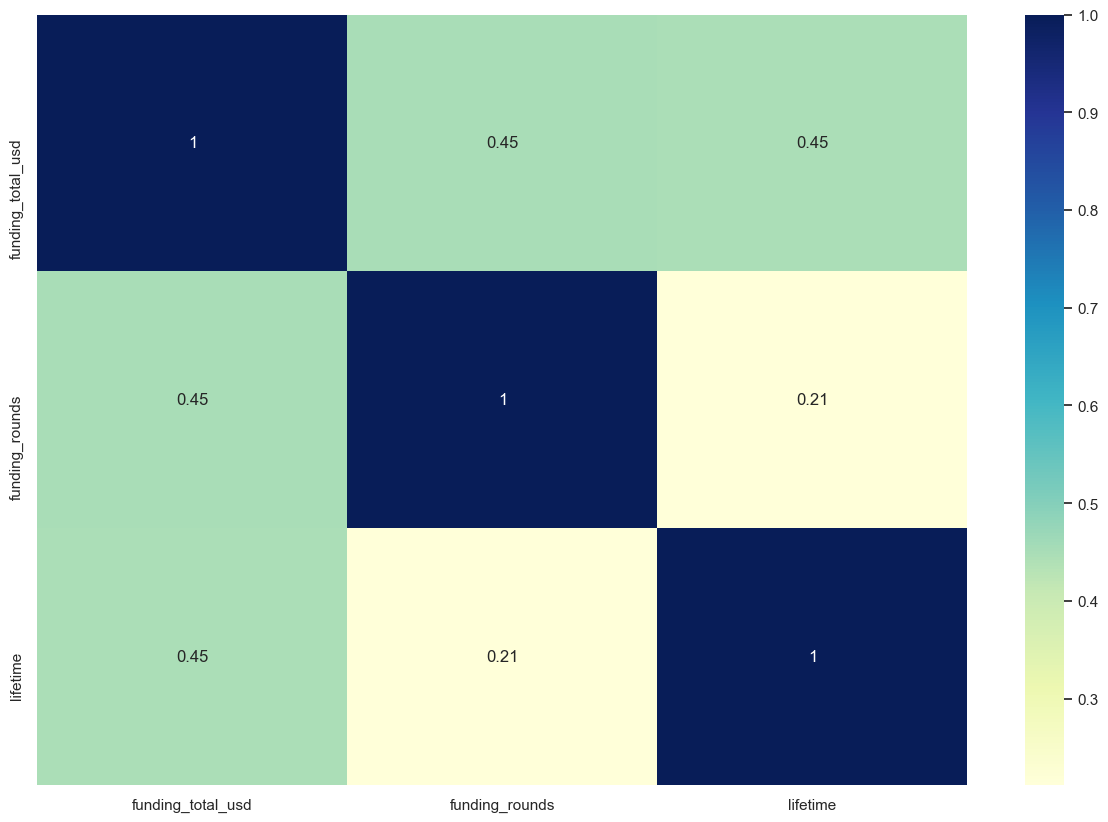

In [51]:
#sns.heatmap(startups_test.corr(method='spearman'), cmap="YlGnBu", annot=True);

In [74]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    startups_test.phik_matrix(
        #interval_cols=['lifetime','funding_rounds','funding_total_usd']
    ), 
    annot=True, 
    cmap='coolwarm'
)

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime']


KeyboardInterrupt: 

<Figure size 1400x1000 with 0 Axes>

## Подготовка данных

### Добавление бинарных признаков из полученного списка уникальных категорий

In [53]:
startups_data_copy = startups_data.copy()
startups_test_copy = startups_test.copy()
for column_name in categories:
    startups_data_copy[column_name] = np.nan
    startups_test_copy[column_name] = np.nan

#### Добавление в датасет ``startups_data``

In [54]:
startups_data_categorized = startups_data_copy.combine_first(categories_from_category_list_data)

In [55]:
startups_data_categorized.head(3)

,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Adaptive Equipment,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,Aerospace,Agriculture,Air Pollution Control,Algorithms,All Markets,All Students,Alternative Medicine,Alumni,Analytics,Android,Angels,Animal Feed,Anything Capital Intensive,App Discovery,App Marketing,App Stores,Application Performance Monitoring,Application Platforms,Apps,Aquaculture,Architecture,Archiving,Art,Artificial Intelligence,Artists Globally,Assisitive Technology,Assisted Living,Auctions,Audio,Audiobooks,Augmented Reality,Auto,Automated Kiosk,Automotive,B2B,B2B Express Delivery,BPO Services,Babies,Baby Accessories,Baby Boomers,Baby Safety,Banking,Batteries,Beauty,Bicycles,Big Data,Big Data Analytics,Billing,Bio-Pharm,Biofuels,Bioinformatics,Biomass Power Generation,Biometrics,Biotechnology,Biotechnology and Semiconductor,Bitcoin,Blogging Platforms,Boating Industry,Brand Marketing,Brewing,Bridging Online and Offline,Broadcasting,Brokers,Browser Extensions,Building Owners,Building Products,Business Analytics,Business Development,Business Information Systems,Business Intelligence,Business Productivity,Business Services,Business Travelers,CAD,CRM,Cable,Call Center Automation,Cannabis,Carbon,Career Management,Career Planning,Cars,Casual Games,Cause Marketing,Celebrity,Certification Test,Charities,Charity,Charter Schools,Chat,Chemicals,Child Care,China Internet,Civil Engineers,Classifieds,Clean Energy,Clean Technology,Clean Technology IT,Clinical Trials,Cloud Computing,Cloud Data Services,Cloud Gaming,Cloud Infrastructure,Cloud Management,Cloud Security,Cloud-Based Music,Coffee,Collaboration,Collaborative Consumption,Collectibles,College Campuses,College Recruiting,Colleges,Comics,Commercial Real Estate,Commercial Solar,Commodities,Communications Hardware,Communications Infrastructure,Communities,Comparison Shopping,Computer Vision,Computers,Concentrated Solar Power,Concerts,Console Gaming,Construction,Consulting,Consumer Behavior,Consumer Electronics,Consumer Goods,Consumer Internet,Consumer Lending,Consumers,Contact Centers,Contact Management,Content,Content Creators,Content Delivery,Content Discovery,Content Syndication,Contests,Cooking,Corporate IT,Corporate Training,Corporate Wellness,Cosmetic Surgery,Cosmetics,Coupons,Coworking,Craft Beer,Creative,Creative Industries,Credit,Credit Cards,Crowdfunding,Crowdsourcing,Cryptocurrency,Curated Web,Custom Retail,Customer Service,Customer Support Tools,Cyber,Cyber Security,DIY,DOD/Military,Darknet,Data Center Automation,Data Center Infrastructure,Data Centers,Data Integration,Data Mining,Data Privacy,Data Security,Data Visualization,Databases,Debt Collecting,Deep Information Technology,Defense,Delivery,Demographies,Dental,Design,Designers,Developer APIs,Developer Tools,Development Platforms,Diabetes,Diagnostics,Dietary Supplements,Digital Entertainment,Digital Media,Digital Rights Management,Digital Signage,Direct Advertising,Direct Marketing,Direct Sales,Discounts,Displays,Disruptive Models,Distribution,Distributors,Diving,Doctors,Document Management,Domains,Drones,E-Books,E-Commerce,E-Commerce Platforms,EBooks,EDA Tools,Early Stage IT,Early-Stage Technology,East Africa,EdTech,Ediscovery,Education,Educational Games,Edutainment,Elder Care,Elderly,Electric Vehicles,Electrical Distribution,Electronic Health Records,Electronics,Email,Email Marketing,Email Newsletters,Embedded Hardware and Software,Emerging Markets,Employer Benefits Programs,Employment,Energy,Energy Efficiency,Energy IT,Energy Management,Energy Storage,Engineering Firms,English-Speaking,Enterprise 2.0,Enterprise Application,Enterprise Hardware,Enterprise Purchasing,Enterprise Resource Planning,Enterprise Search,Enterprise Security,Enterprise Software,Enterprises,Entertainment,Entertainment Industry,Entrepreneur,Environmental Innovation,Estimation and Quoting,Event Management,Events,Exercise,Experience Design,

Проверка объединения по категории **Manufacturing**

In [56]:
(startups_data_categorized[startups_data_categorized['category_list']
     .str.contains('Manufacturing', na=False)][['name', 'Manufacturing', 'category_list']]
     .head(5))

,name,Manufacturing,category_list
1,EarLens,1.00,Manufacturing|Medical|Medical Devices
4,WireTough Cylinders,1.00,Manufacturing
32,Plex Systems,1.00,Cloud Computing|Enterprise Resource Planning|M...
62,Myers Motors,1.00,Manufacturing
84,SpectraSensors,1.00,Manufacturing


<span style="color: darkgreen">Данные объединены корректно.</span>

#### Добавление в датасет ``startups_test``

In [57]:
startups_test_categorized = startups_test_copy.combine_first(categories_from_category_list_test)

In [58]:
startups_test_categorized.head(5)

,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Adaptive Equipment,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,Aerospace,Agriculture,Air Pollution Control,Algorithms,All Markets,All Students,Alternative Medicine,Alumni,Analytics,Android,Angels,Animal Feed,Anything Capital Intensive,App Discovery,App Marketing,App Stores,Application Performance Monitoring,Application Platforms,Apps,Aquaculture,Architecture,Archiving,Art,Artificial Intelligence,Artists Globally,Assisitive Technology,Assisted Living,Auctions,Audio,Audiobooks,Augmented Reality,Auto,Automated Kiosk,Automotive,B2B,B2B Express Delivery,BPO Services,Babies,Baby Accessories,Baby Boomers,Baby Safety,Banking,Batteries,Beauty,Bicycles,Big Data,Big Data Analytics,Billing,Bio-Pharm,Biofuels,Bioinformatics,Biomass Power Generation,Biometrics,Biotechnology,Biotechnology and Semiconductor,Bitcoin,Blogging Platforms,Boating Industry,Brand Marketing,Brewing,Bridging Online and Offline,Broadcasting,Brokers,Browser Extensions,Building Owners,Building Products,Business Analytics,Business Development,Business Information Systems,Business Intelligence,Business Productivity,Business Services,Business Travelers,CAD,CRM,Cable,Call Center Automation,Cannabis,Carbon,Career Management,Career Planning,Cars,Casual Games,Cause Marketing,Celebrity,Certification Test,Charities,Charity,Charter Schools,Chat,Chemicals,Child Care,China Internet,Civil Engineers,Classifieds,Clean Energy,Clean Technology,Clean Technology IT,Clinical Trials,Cloud Computing,Cloud Data Services,Cloud Gaming,Cloud Infrastructure,Cloud Management,Cloud Security,Cloud-Based Music,Coffee,Collaboration,Collaborative Consumption,Collectibles,College Campuses,College Recruiting,Colleges,Comics,Commercial Real Estate,Commercial Solar,Commodities,Communications Hardware,Communications Infrastructure,Communities,Comparison Shopping,Computer Vision,Computers,Concentrated Solar Power,Concerts,Console Gaming,Construction,Consulting,Consumer Behavior,Consumer Electronics,Consumer Goods,Consumer Internet,Consumer Lending,Consumers,Contact Centers,Contact Management,Content,Content Creators,Content Delivery,Content Discovery,Content Syndication,Contests,Cooking,Corporate IT,Corporate Training,Corporate Wellness,Cosmetic Surgery,Cosmetics,Coupons,Coworking,Craft Beer,Creative,Creative Industries,Credit,Credit Cards,Crowdfunding,Crowdsourcing,Cryptocurrency,Curated Web,Custom Retail,Customer Service,Customer Support Tools,Cyber,Cyber Security,DIY,DOD/Military,Darknet,Data Center Automation,Data Center Infrastructure,Data Centers,Data Integration,Data Mining,Data Privacy,Data Security,Data Visualization,Databases,Debt Collecting,Deep Information Technology,Defense,Delivery,Demographies,Dental,Design,Designers,Developer APIs,Developer Tools,Development Platforms,Diabetes,Diagnostics,Dietary Supplements,Digital Entertainment,Digital Media,Digital Rights Management,Digital Signage,Direct Advertising,Direct Marketing,Direct Sales,Discounts,Displays,Disruptive Models,Distribution,Distributors,Diving,Doctors,Document Management,Domains,Drones,E-Books,E-Commerce,E-Commerce Platforms,EBooks,EDA Tools,Early Stage IT,Early-Stage Technology,East Africa,EdTech,Ediscovery,Education,Educational Games,Edutainment,Elder Care,Elderly,Electric Vehicles,Electrical Distribution,Electronic Health Records,Electronics,Email,Email Marketing,Email Newsletters,Embedded Hardware and Software,Emerging Markets,Employer Benefits Programs,Employment,Energy,Energy Efficiency,Energy IT,Energy Management,Energy Storage,Engineering Firms,English-Speaking,Enterprise 2.0,Enterprise Application,Enterprise Hardware,Enterprise Purchasing,Enterprise Resource Planning,Enterprise Search,Enterprise Security,Enterprise Software,Enterprises,Entertainment,Entertainment Industry,Entrepreneur,Environmental Innovation,Estimation and Quoting,Event Management,Events,Exercise,Experience Design,

Проверка объединения по категории **Software**

In [59]:
(startups_test_categorized[startups_test_categorized['category_list']
     .str.contains('Software', na=False)][['name', 'Software', 'category_list']]
     .head(5))

,name,Software,category_list
3,Imagine Communications,1.00,Software|Video|Video Streaming
4,DNA13,1.00,Software
8,Urgent.ly,1.00,Software
9,Map Decisions,1.00,Software
26,Talkway Communications,1.00,Communications Infrastructure|Internet|Software


<span style="color: darkgreen">Данные объединены корректно.</span>

In [60]:
startups_data_categorized.shape

(52516, 872)

In [61]:
startups_test_categorized.shape

(13125, 871)

Количество колонок отличается из-за целевого признака.

In [62]:
#plt.figure(figsize=(14, 10))
#sns.heatmap(
    #startups_test_categorized.phik_matrix(
        #interval_cols=categories
    #), 
    #annot=True, 
    #cmap='coolwarm'
#)
#plt.show()
#sns.heatmap(startups_test_categorized.corr(method='spearman'), cmap="YlGnBu", annot=True);

In [63]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [64]:
num_columns = startups_data.select_dtypes('float').columns
num_data = startups_data[num_columns]

In [65]:
imp.fit(num_data)

SimpleImputer()

In [66]:
out = imp.transform(num_data)

In [67]:
out

array([[  828626.],
       [42935019.],
       [35456381.],
       ...,
       [   50000.],
       [13000000.],
       [  270820.]])

In [68]:
startups_data['status'].unique()

array(['operating', 'closed'], dtype=object)

In [69]:
#crystalsol = startups_test[startups_test['name'] == 'Crystalsol']

In [70]:
startups_data.isna().sum()

name                     0
category_list            0
funding_total_usd    10069
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [71]:
len(startups_data[startups_data.duplicated(subset=[\
    'name'])])

0

In [72]:
len(startups_data['category_list'].unique())

22106